<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Epidemiology 103</h1>
<h1>Adding confidence intervals to your CoVID19</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from tqdm import tqdm

from EpiModel import *

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.23.0

Compiler    : Clang 11.0.3 (clang-1103.0.32.62)
OS          : Darwin
Release     : 20.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

Git hash: 6e93348d755937d401f22033fc13952203854f4a

numpy     : 1.20.2
watermark : 2.2.0
pandas    : 1.2.4
networkx  : 2.5.1
sys       : 3.8.5 (default, Jul 21 2020, 10:48:26) 
[Clang 11.0.3 (clang-1103.0.32.62)]
scipy     : 1.6.3
matplotlib: 3.4.1



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# SIR Model

As before, we start by considering the simple SIR model as it is easy to understand and it contains enough features for our purposes 

In [78]:
# Exposure factor
beta = 0.75
# Sympotmatic vs Asymptomatic
pa = 0.4
rb = 0.75
# Recovery rate
mu = 0.01
eps = 0.5
# Re-infection rate
rho = 0.01
# Death rate
pd = 0.02

SIR = EpiModel()
SIR.add_interaction('S', 'E', 'Is', beta)
SIR.add_interaction('S', 'E', 'Ia', beta*rb)

SIR.add_spontaneous('E', 'Is', eps*(1-pa))
SIR.add_spontaneous('E', 'Ia', eps*pa)

SIR.add_spontaneous('Ia', 'R', mu)
SIR.add_spontaneous('Is', 'R', mu*(1-pd))
SIR.add_spontaneous('R', 'S', rho)
SIR.add_spontaneous('Is', 'D', mu*pd)


We can see that the model has been properly defined

In [79]:
print(SIR)

Epidemic Model with 6 compartments and 8 transitions:

S + Is = E 0.750000
S + Ia = E 0.562500
E -> Is 0.300000
E -> Ia 0.200000
Is -> R 0.009500
Is -> D 0.000500
Ia -> R 0.010000
R -> S 0.010000



One of the issues with simply numerically integrating the differential equations is that we can seed an epidemic with a fraction of a person:

In [85]:
N = 112374333
I0 = 2000000
R0 = 2000000

SIR.integrate(365, S=N-I0, Ia=I0/2, Is=I0/2, R=R0, E=0, D=0)

Without any significant difference in terms of the evolution of the epidemic

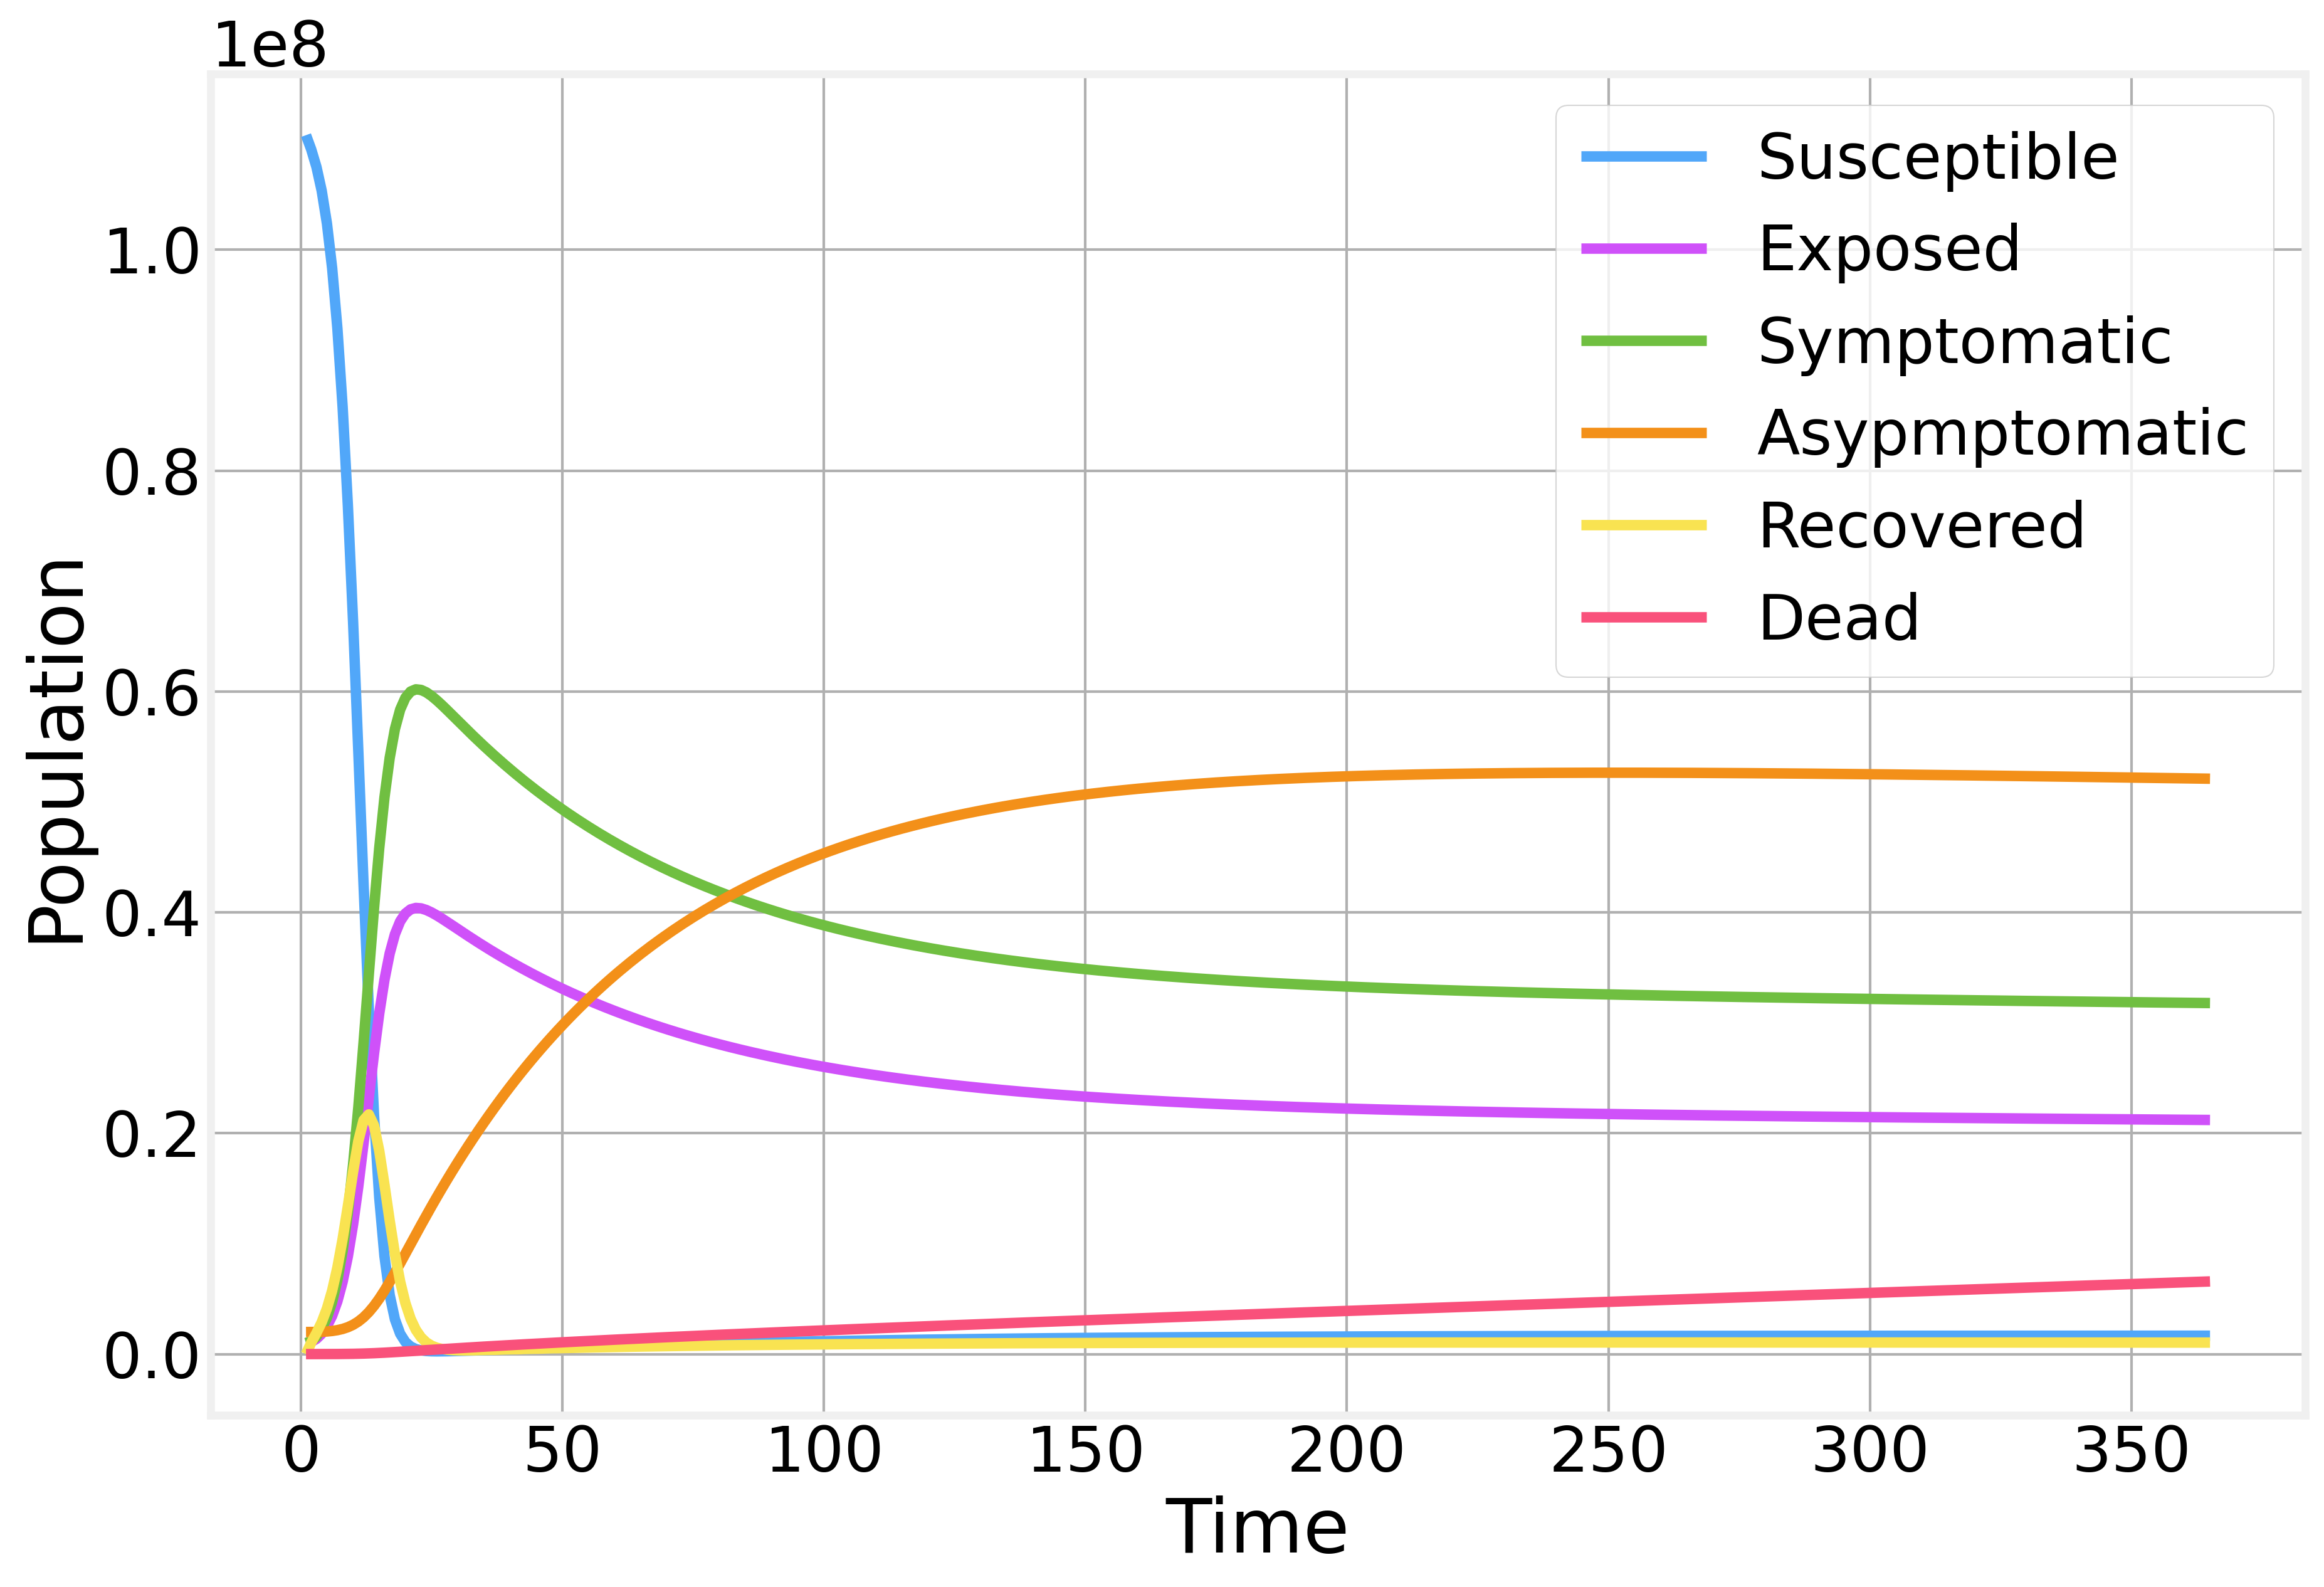

In [87]:
ax = SIR.plot(normed=False, grid=True)
ax.legend(['Susceptible', 'Exposed', 'Symptomatic', 'Asypmptomatic', 'Recovered', 'Dead'])

Except that we have fractions of individuals:

In [69]:
SIR.values_.iloc[:10]

S        Ia        Is         R         E         D
1   99999.900000  0.000000  0.100000  0.000000  0.000000  0.000000
2   99999.848770  0.004300  0.105456  0.000976  0.040447  0.000051
3   99999.790163  0.015429  0.121163  0.002124  0.071014  0.000107
4   99999.718032  0.032307  0.145505  0.003590  0.100393  0.000173
5   99999.626587  0.055180  0.178848  0.005510  0.133621  0.000254
6   99999.509355  0.085126  0.222812  0.008036  0.174316  0.000354
7   99999.358442  0.123894  0.280017  0.011354  0.225815  0.000479
8   99999.163884  0.173901  0.354090  0.015695  0.291794  0.000637
9   99998.912920  0.238345  0.449829  0.021358  0.376711  0.000837
10  99998.589133  0.321390  0.573478  0.028726  0.486182  0.001091

Which is somewhat unrealistic.

# Stochastic model

One way of getting arround this issue is to simulate the model stochastically instead of integrating the equation. Essentially, at each time step we use probabilities to calculate how many individuals transition from one compartment to another and them move them.

Our __EpiModel__ class provides this functionality throught the __simulate()__ function, which has a similar interface than the __integrate()__ function we're already familiar with

In [76]:
N = 100000
I0 = 10

SIR.simulate(365, S=N-I0, Ia=I0, Is=I0, R=0, E=0, D=0)

If we start with a sufficient number of infectious seeding individuals, the end result is similar to the one obtained by numerical integration

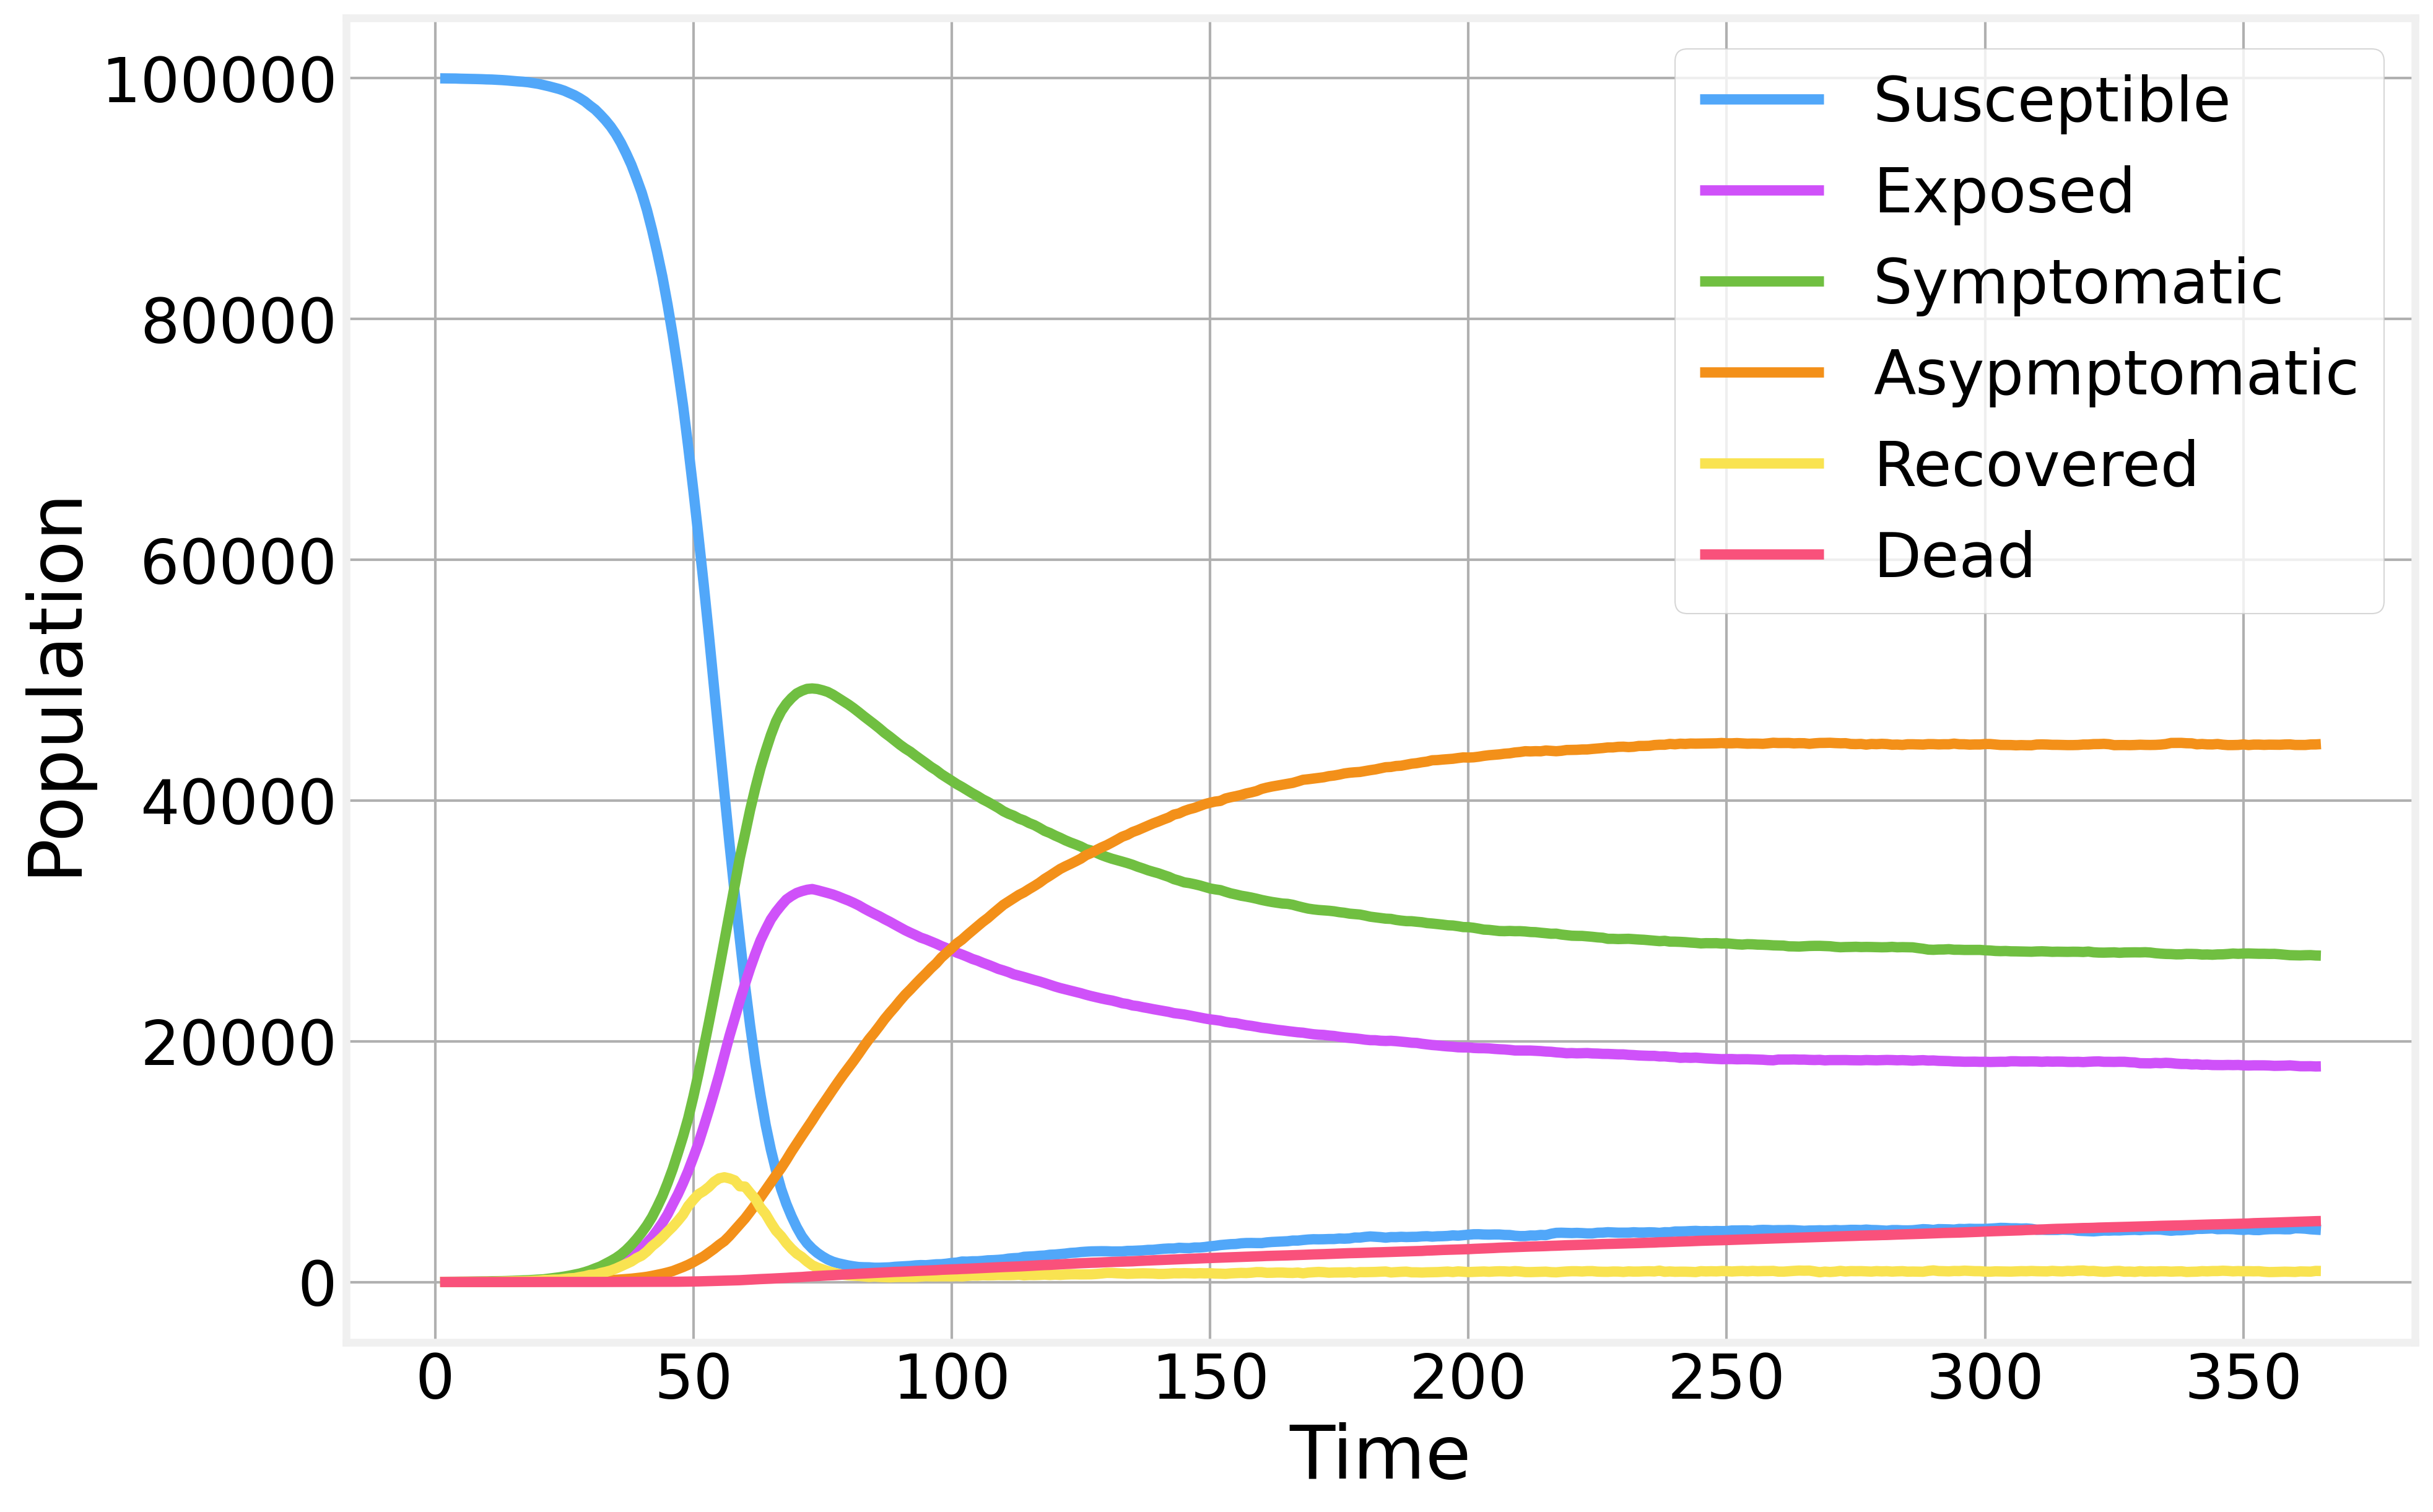

In [77]:
ax = SIR.plot(normed=False)
ax.legend(['Susceptible', 'Exposed', 'Symptomatic', 'Asypmptomatic', 'Recovered', 'Dead'])

but now all the values are integer. No more fractional people!

In [49]:
SIR.values_.iloc[:10]

S   E  Is  Ia  R  D
1   99988   9  10   1  2  0
2   99986   9  10   3  2  0
3   99986  10   9   4  1  0
4   99985  11   9   4  1  0
5   99984  10   9   6  1  0
6   99982  11   9   6  2  0
7   99980  13   8   7  2  0
8   99980  15   6   9  0  0
9   99978  12   6  12  2  0
10  99976  13   5  13  3  0

One important consequence of this, is that the epidemic can fail to be seeded due to just stochastic effects. For example, if we try to seed an epidemic with just 1 individual, there is a significant probability that the seed with recover before being able to infect anybody else. 

You might need to run the following cell a few times before observing it

In [15]:
I0 = 1
SIR.simulate(365, S=N-I0, I=I0, R=0)
SIR.values_.iloc[:10]

S  I  R
1   99999  1  0
2   99999  1  0
3   99999  1  0
4   99999  1  0
5   99999  1  0
6   99998  2  0
7   99998  1  1
8   99998  1  1
9   99998  1  1
10  99998  1  1

# Multiple runs

Another advantage of performing a simulation instead of a numerical integration is that every time we run our simulation we will get a sightly different result. This is a simple example of [Monte Carlo Simulation](https://en.wikipedia.org/wiki/Monte_Carlo_method).

We can obtain a simple visualization of this effect by performing 100 individual runs and ploting the number of people in the infectious compartments for all of them:

100%|██████████| 1000/1000 [01:00<00:00, 16.40it/s]


Text(0, 0.5, 'Population')

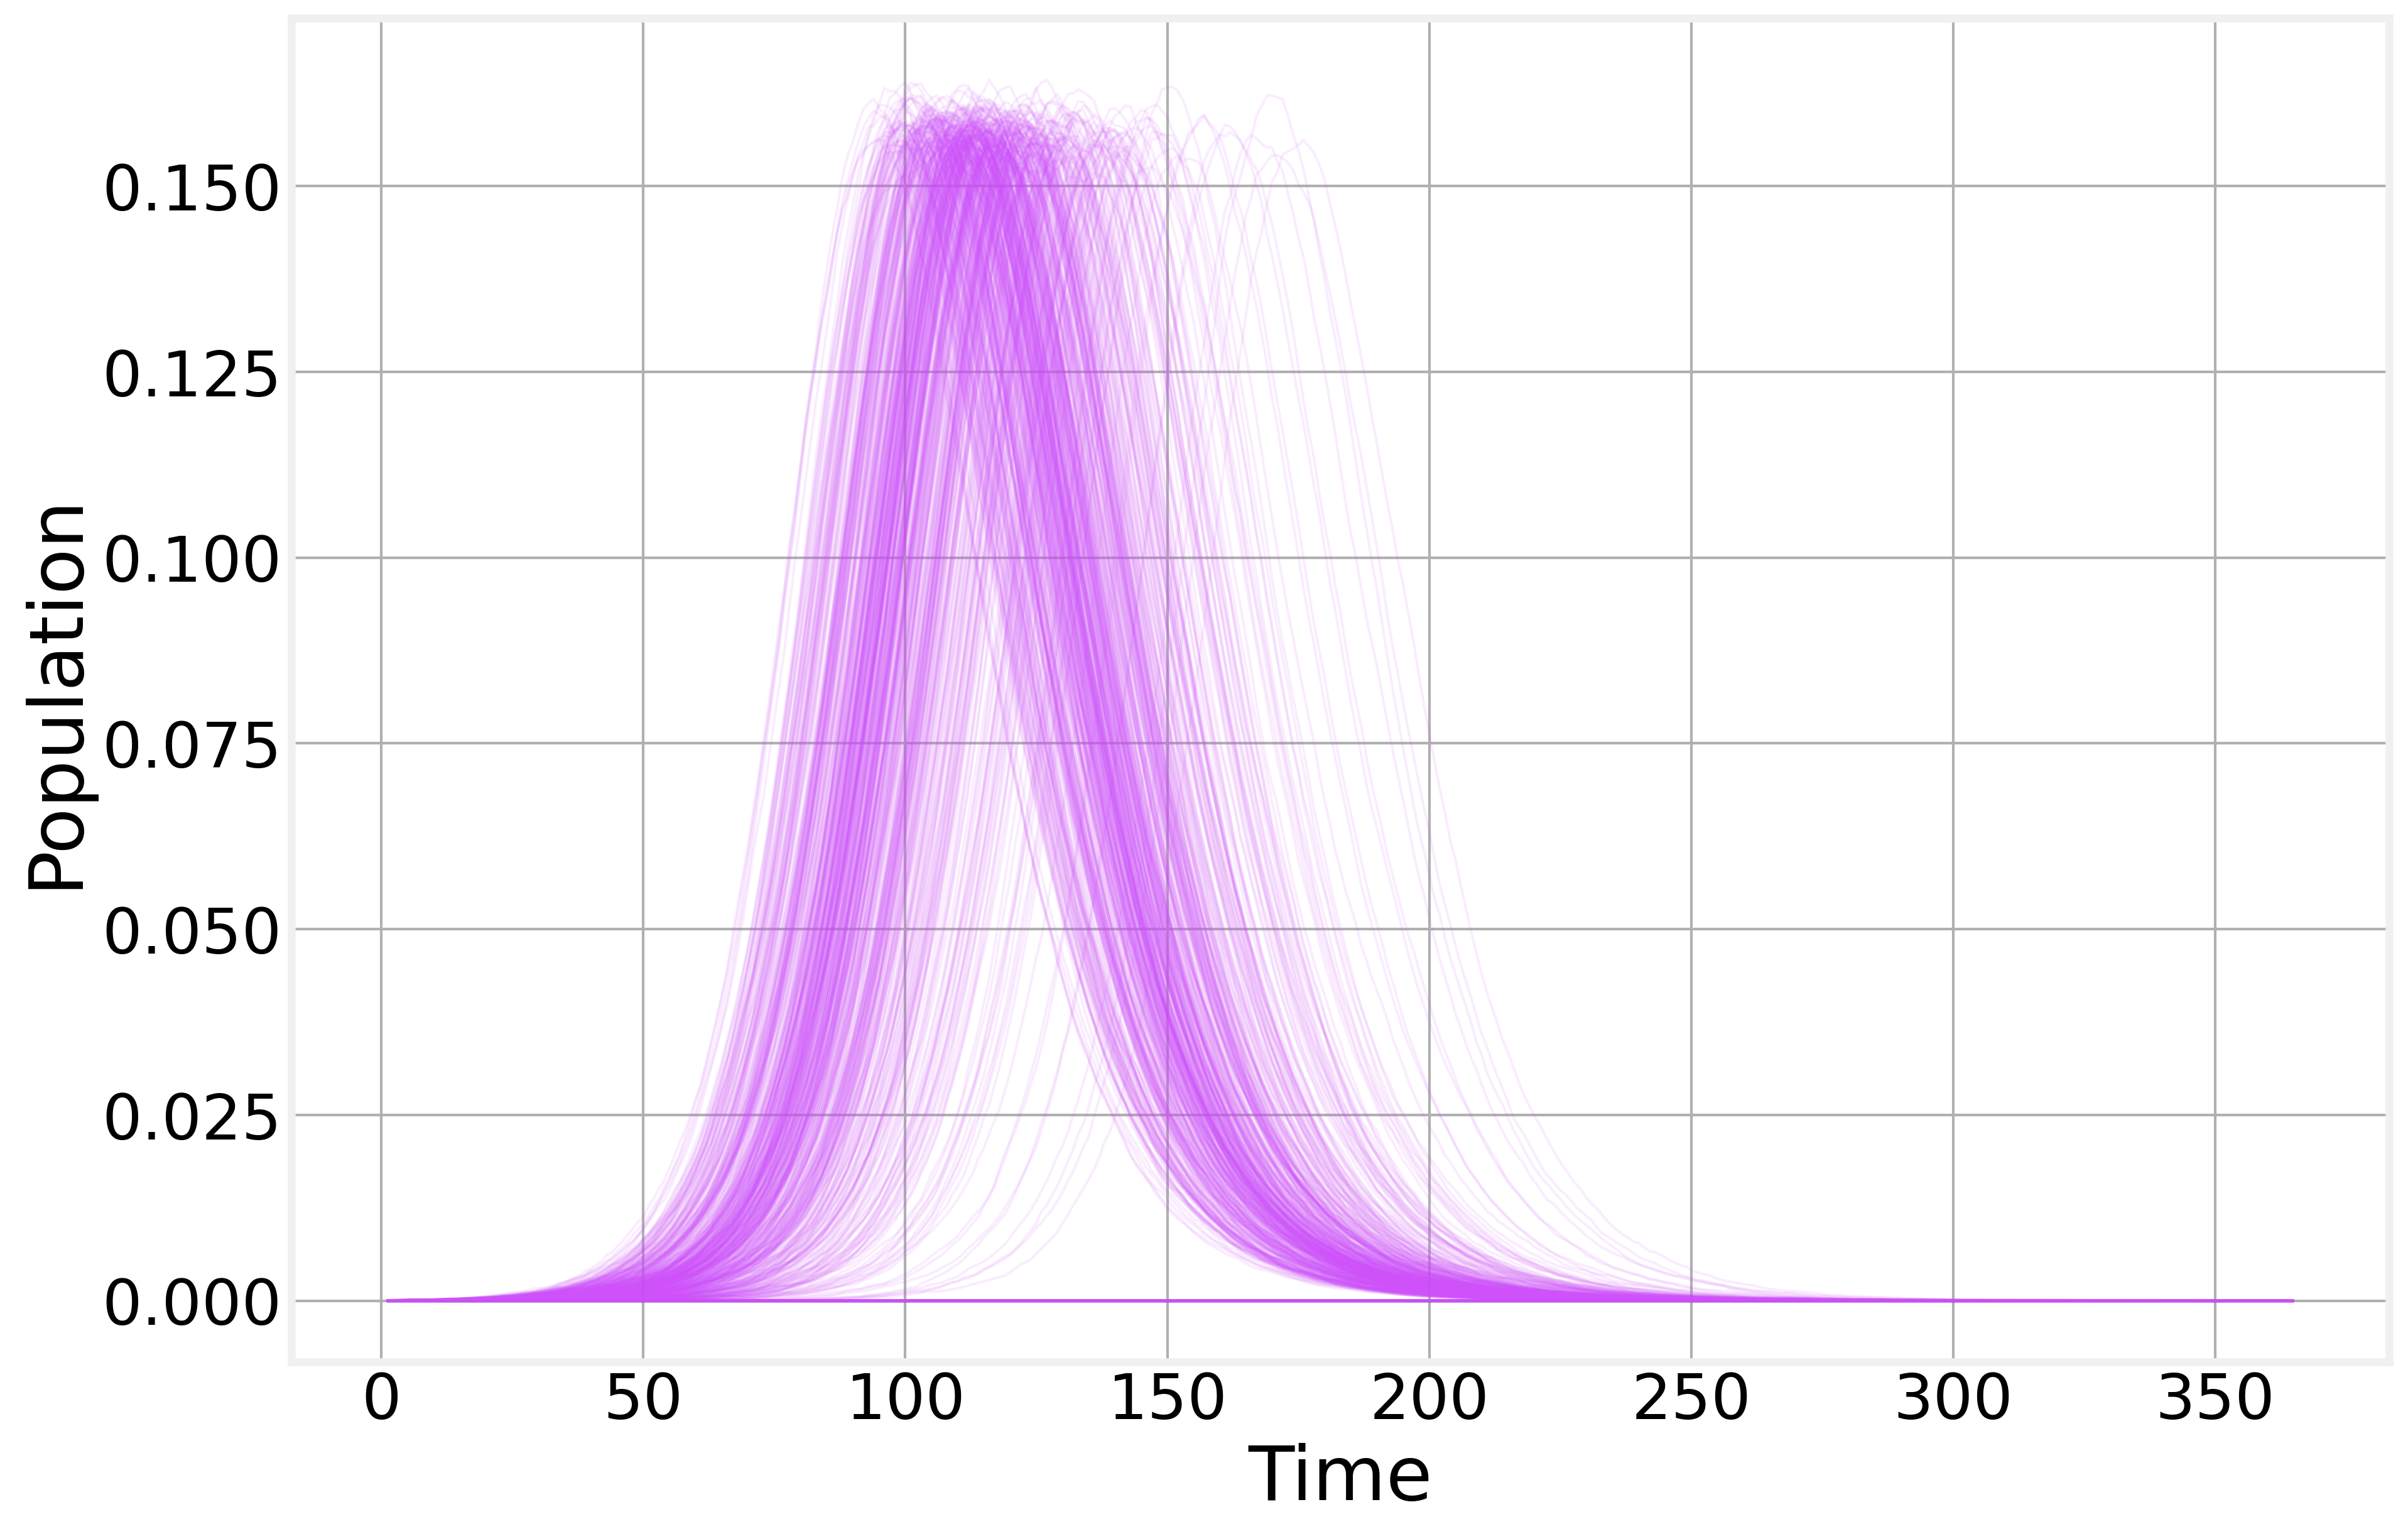

In [16]:
Nruns = 1000

full = None

fig, ax = plt.subplots(1)

for run in tqdm(range(Nruns), total=Nruns):
    SIR.simulate(365, S=N-I0, I=I0, R=0)
    ax.plot(SIR.I/N, lw=1, alpha=0.1, c=colors[1])
    
    if full is None:
        full = SIR.I.copy()
    else:
        full = pd.concat([full, SIR.I], axis=1)
        
full.columns=np.arange(Nruns)
ax.set_xlabel('Time')
ax.set_ylabel('Population')

In the plot above, each individual line corresponds to a single individual run. As we can see, while each run behavior **similarly** they're also all slightly differently, giving us a better perspective on what is the natural variability we may expect to see in the real world

We can summarize the results of all the simulations usign the median value for each point in time and the 95% confidence interval. For comparison, we also include the curve obtained from the numerial integration approach we've been using so far

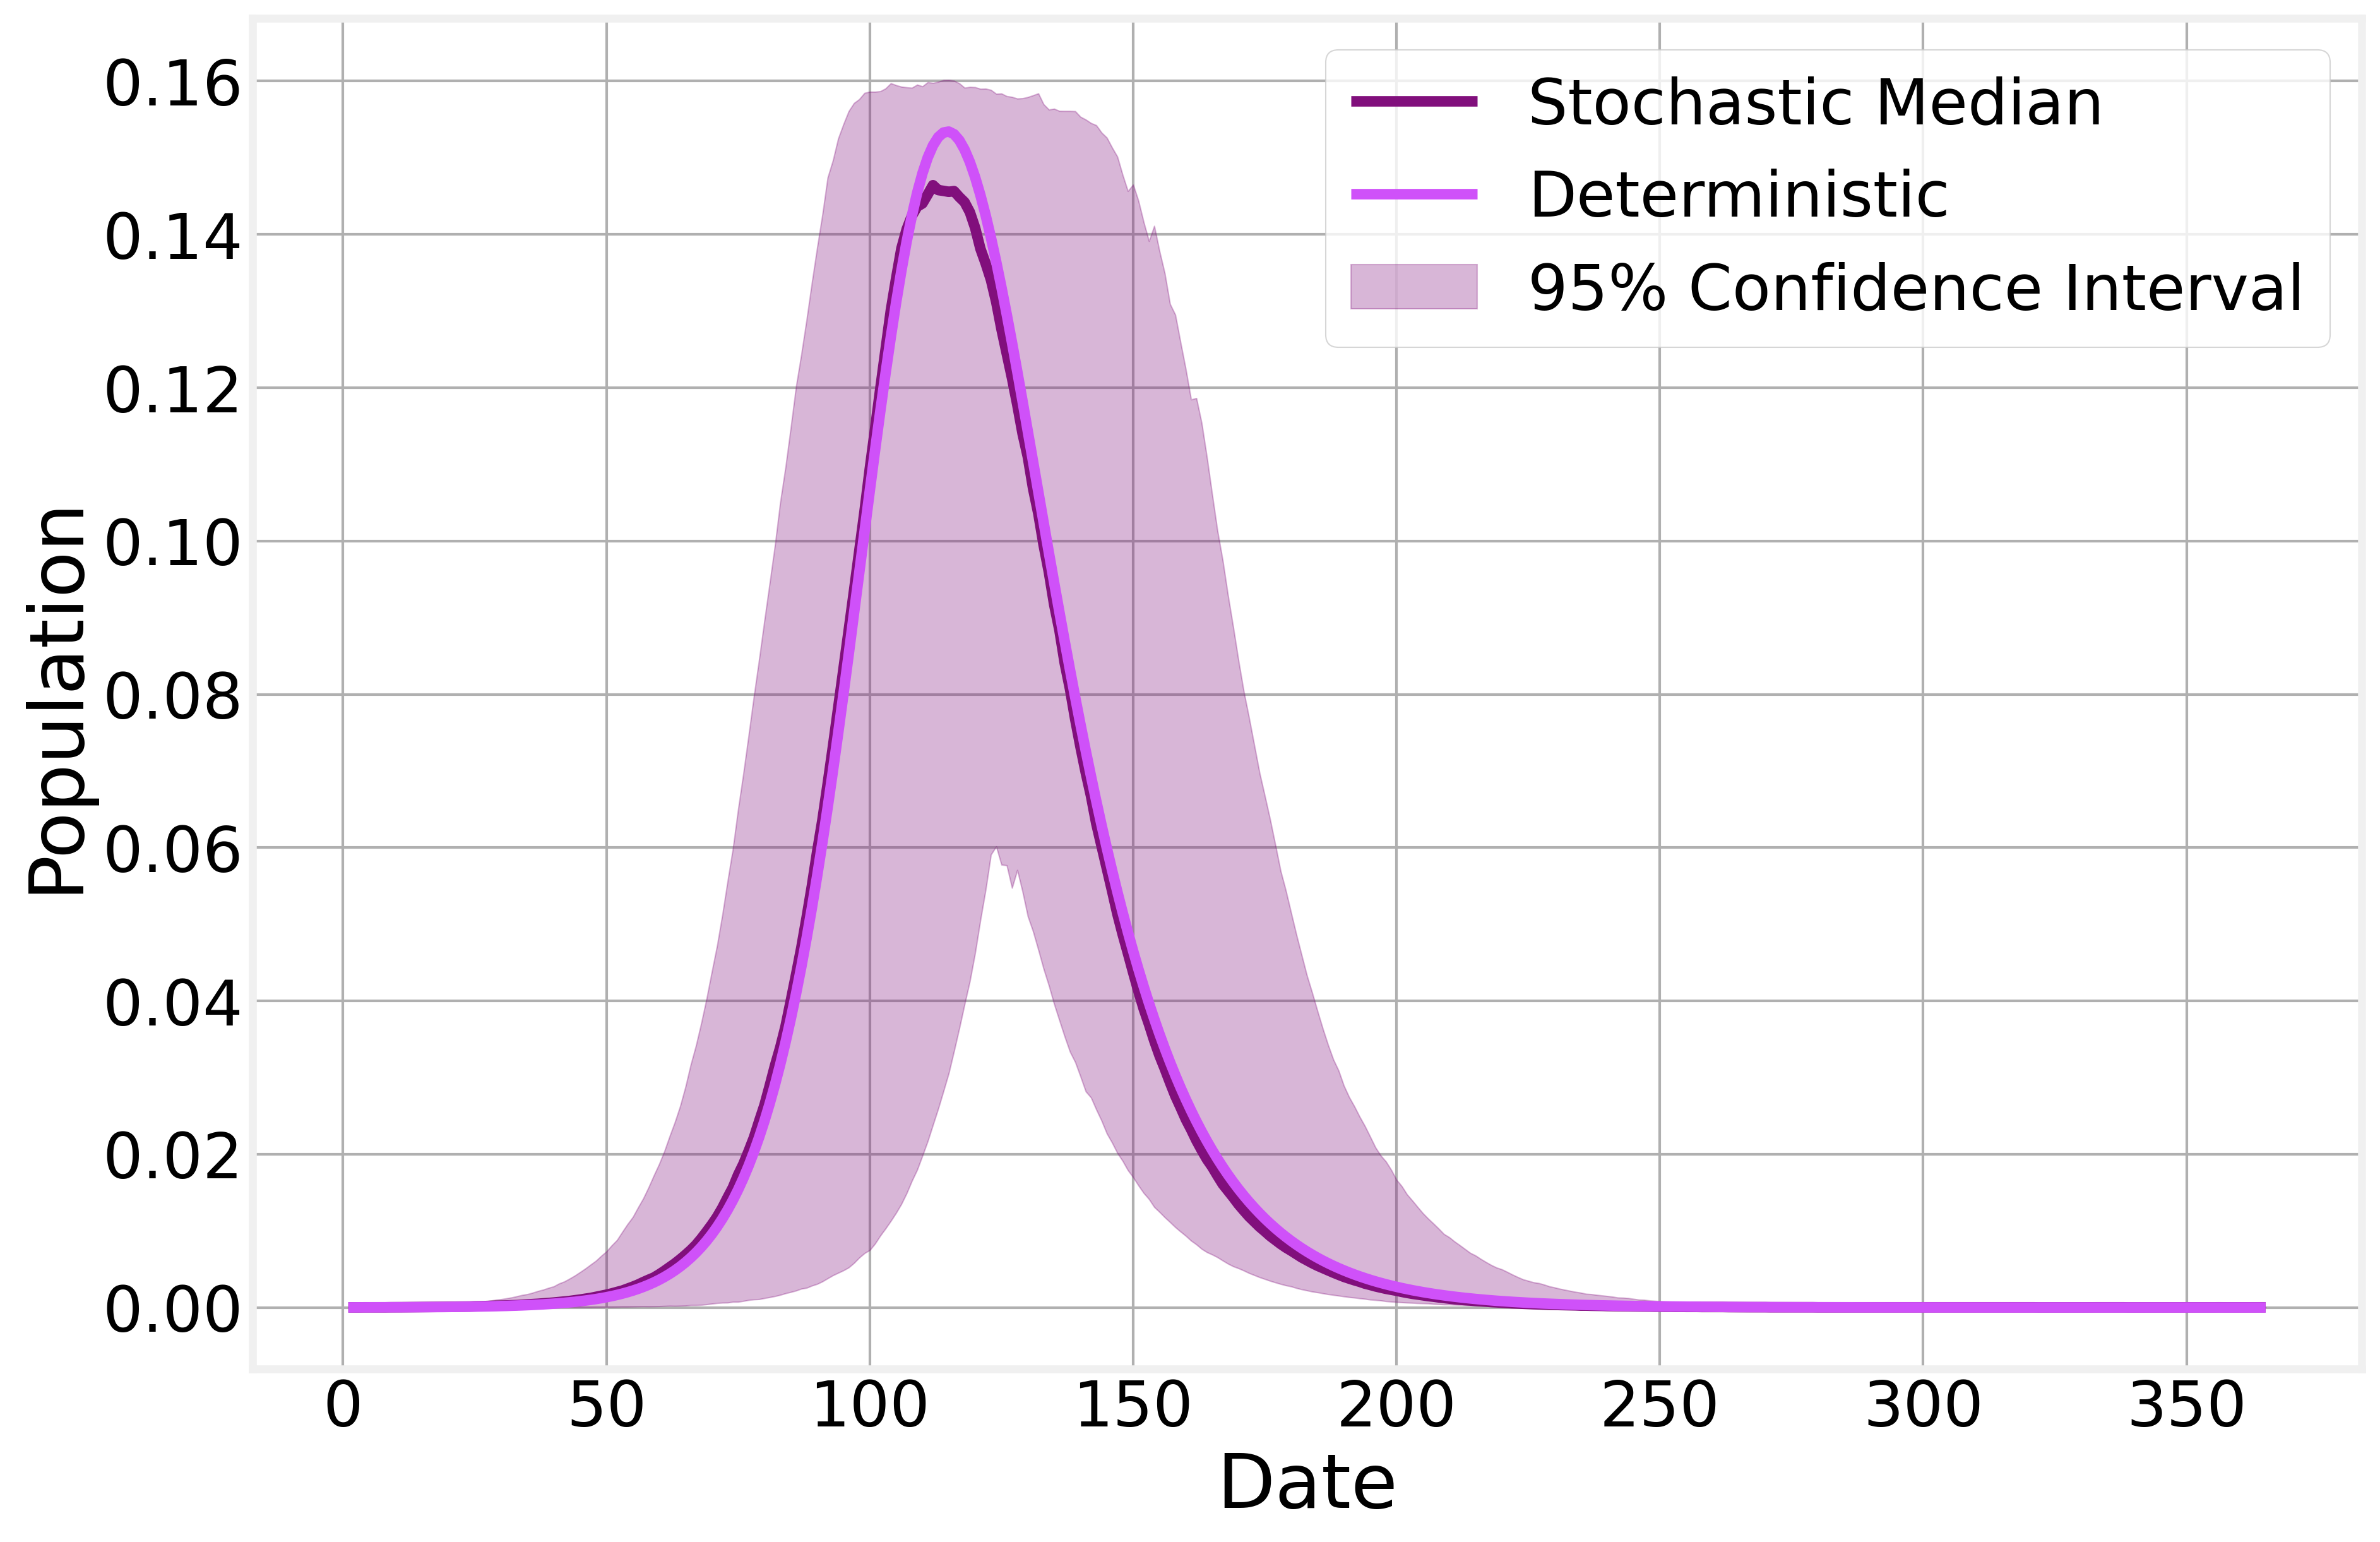

In [20]:
ax = (full.apply(lambda x: x[x>0].median(), axis=1)/N).plot(c=colors[8], label='Stochastic Median')

upper = full.apply(lambda x:x[x>0].quantile(0.975), axis=1)/N
lower = full.apply(lambda x:x[x>0].quantile(0.025), axis=1)/N

ax.fill_between(np.arange(1, 366), 
                y1=lower, 
                y2=upper, color=colors[8], alpha=0.3,
                label='95% Confidence Interval')

SIR.integrate(365, S=N-I0, I=I0, R=0)
(SIR.I/N).plot(ax=ax, c=colors[1], label='Deterministic')

ax.set_xlabel('Date')
ax.set_ylabel('Population')
ax.legend()

As we can see, while the median provides us with a similar behavior than the deterministic curve, it also includes a lot more natural variability due to the stochastic nature of the underlying simulations. 

Naturally, the more runs we perform the more information we obtain about the possible range of behaviors we might observe in the real world

# Outbreak probability

The Monte-Carlo approach also allows us to ask a wider range of questions about our epidemic process. For example, what is the probability of actually observing a disease outbreak as a function of $R_0$? From our previous analytical calculation, we saw that the epidemic spreads if $R_0>1$ and dies otherwise, but reality is a bit more complicated than our equations. Let's consider a few values of $R_0$ and see what is the probability of observing an outbreak by performing 100 individual runs. 

For the sake of expediency, let's simulate only the first 30 time steps and define an outbreak as having at least twice the number of seed individuals at some stage of the infection process:

In [21]:
R0_list = np.linspace(0.4, 3, 14)

In [22]:
N = 100000
I0 = 1
Nruns = 1000

counts = {}
sizes = {}

for R0 in R0_list:
    mu = 0.1
    beta = mu*R0

    SIR = EpiModel()
    SIR.add_interaction('S', 'I', 'I', beta)
    SIR.add_spontaneous('I', 'R', mu)    
        
    for run in tqdm(range(Nruns), total=Nruns, desc=r"R0=%1.2f"% R0):
        SIR.simulate(30, S=N-I0, I=I0, R=0)
        
        if N-SIR.S.iloc[-1] > 2*I0:
            counts[R0] = counts.get(R0, 0) + 1
            sizes[R0] = sizes.get(R0, 0) + (N-SIR.S.iloc[-1])

R0=3.00: 100%|██████████| 1000/1000 [00:05<00:00, 193.99it/s]


The outbreak probability as a function of $R_0$ is then

In [23]:
prob = np.array(list(counts.items()))
outbreaks = np.array(list(sizes.items()))

outbreaks.T[1]/=prob.T[1]
prob.T[1]/=Nruns

As we can see, it's possible to start an outbreak even with a value of $R_0<1$. On the other hand, it's also clear than even when $R_0>1$ we can have the disease simply not take hold. Naturally, the larger the value of $R_0$ the larger the outbreak we will see (if one does indeed occur).

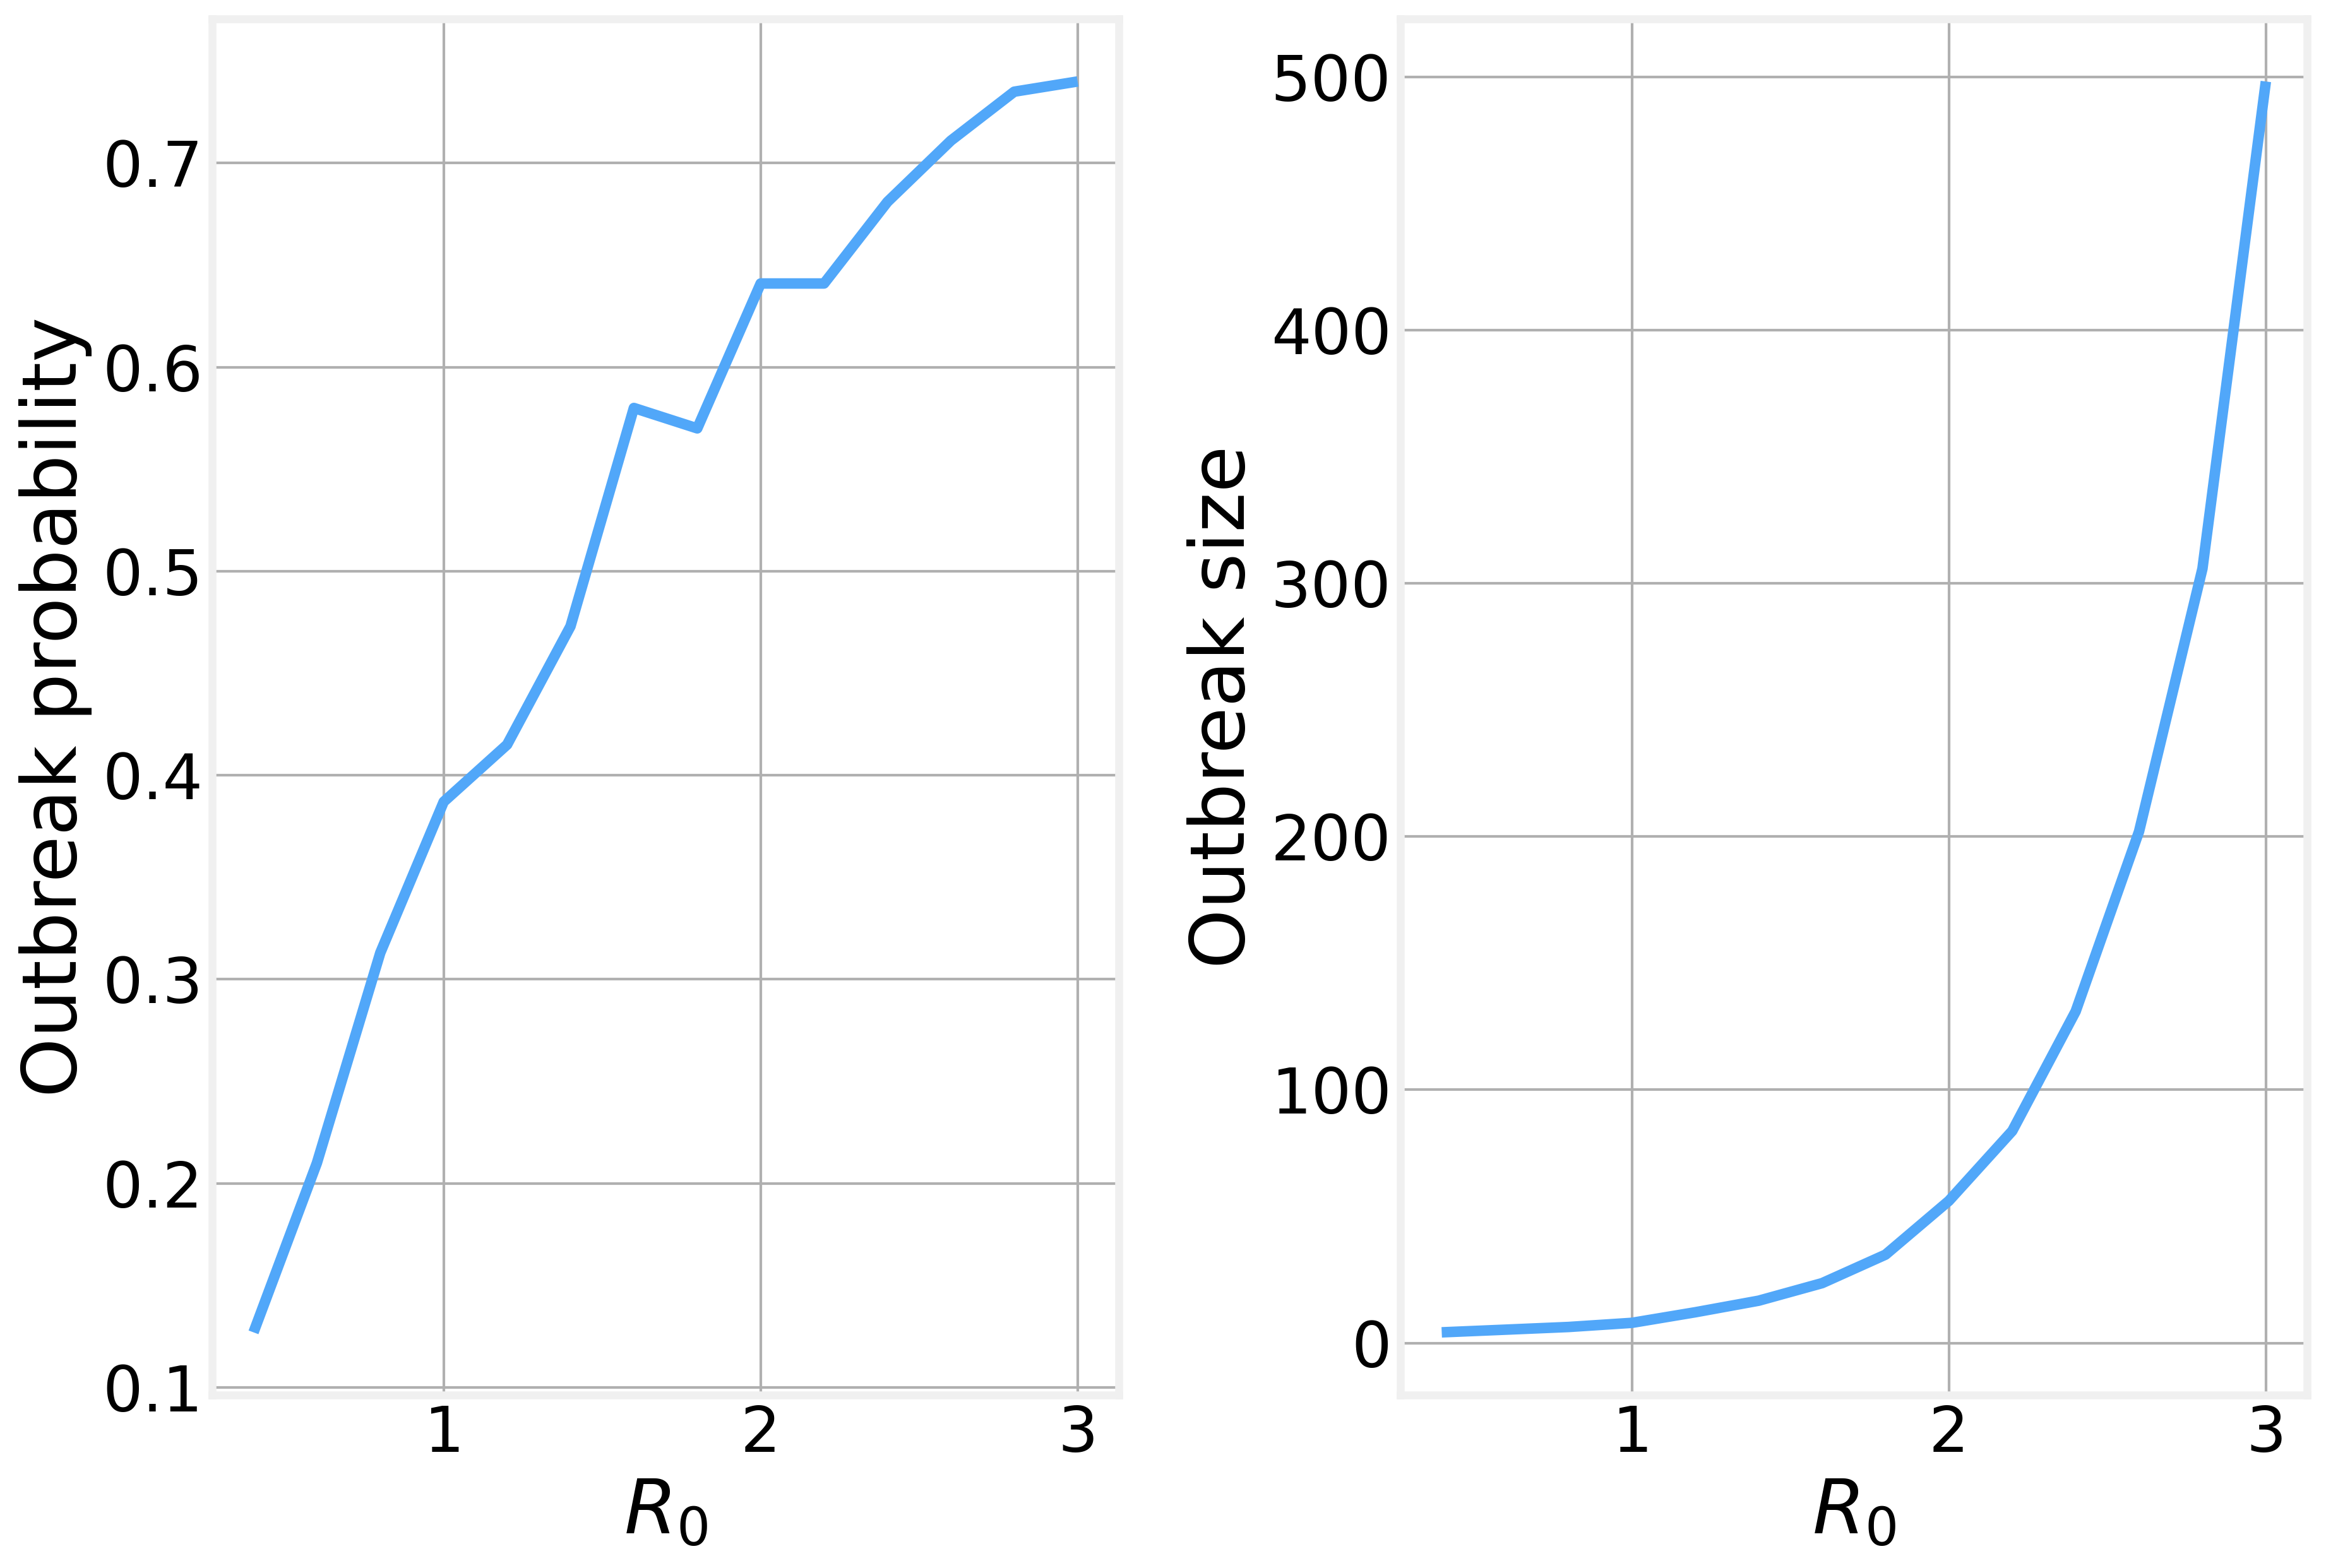

In [24]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(prob.T[0], prob.T[1])
axs[0].set_xlabel(r'$R_0$')
axs[0].set_ylabel('Outbreak probability')

axs[1].plot(outbreaks.T[0], outbreaks.T[1])
axs[1].set_xlabel(r'$R_0$')
axs[1].set_ylabel('Outbreak size')
fig.tight_layout()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>